<a href="https://colab.research.google.com/github/Danielp8s/DLP3/blob/main/PROYECTO_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Primero instalamos las dependencias necesarias
!pip install transformers datasets torch numpy pandas scikit-learn nltk # Instalamos las dependencias principales para procesamiento de datos, PLN y aprendizaje automático
!pip install kaggle # Instalamos la biblioteca 'kaggle' para descargar datasets desde Kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Descargar el dataset
#!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
#!unzip jigsaw-toxic-comment-classification-challenge.zip
#!unzip /content/jigsaw-toxic-comment-classification-challenge.zip


import os
from zipfile import ZipFile

# Ruta al archivo principal
main_zip = "jigsaw-toxic-comment-classification-challenge.zip" # Indicamos el nombre del archivo principal .zip que se desea descomprimir.

# Crear una carpeta para los archivos descomprimidos
output_folder = "./jigsaw_data" # Creamos una carpeta llamada "jigsaw_data" para almacenar los archivos descomprimidos.
os.makedirs(output_folder, exist_ok=True) # Si la carpeta no existe, se crea.

# Descomprimir el archivo principal
with ZipFile(main_zip, 'r') as zip_ref: # Abrimos el archivo principal .zip en modo de lectura y extraemos su contenido en la carpeta creada.
    zip_ref.extractall(output_folder) # Extraemos todos los archivos en "jigsaw_data".
    print("Archivo principal descomprimido.") # Confirmamos la descompresión.

# Verificar si hay archivos .zip internos y descomprimirlos
for root, dirs, files in os.walk(output_folder): # Recorremos el árbol de directorios dentro de la carpeta "jigsaw_data" buscando más archivos .zip.
    for file in files: # Iteramos sobre los archivos encontrados.
        if file.endswith(".zip"): # Si el archivo tiene extensión .zip:
            internal_zip_path = os.path.join(root, file) # Construimos la ruta completa del archivo .zip.
            internal_output_folder = os.path.join(root, file.replace(".zip", "")) # Creamos una carpeta con el nombre del archivo (sin extensión).
            os.makedirs(internal_output_folder, exist_ok=True) # Crear la carpeta para el archivo .zip interno

            # Descomprimir el archivo .zip interno
            with ZipFile(internal_zip_path, 'r') as zip_ref:  # Abrimos el archivo .zip interno y extraemos su contenido en la carpeta correspondiente.
                zip_ref.extractall(internal_output_folder) # Extraemos los archivos en la carpeta creada.
                print(f"Descomprimido: {file} en {internal_output_folder}") # Confirmamos la descompresión.


Archivo principal descomprimido.
Descomprimido: test.csv.zip en ./jigsaw_data/test.csv
Descomprimido: train.csv.zip en ./jigsaw_data/train.csv
Descomprimido: sample_submission.csv.zip en ./jigsaw_data/sample_submission.csv
Descomprimido: test_labels.csv.zip en ./jigsaw_data/test_labels.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [ ]:
# Descargar recursos de NLTK
nltk.download('punkt') # Descarga el tokenizer 'punkt' para dividir texto en oraciones o palabras.
nltk.download('stopwords') # Descarga una lista de palabras vacías (stopwords) para filtrar palabras comunes como "el", "y", "de"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Definir las rutas correctas
TRAIN_PATH = "/content/jigsaw_data/train.csv/train.csv" # Ruta al archivo de datos de entrenamiento.
TEST_PATH = "/content/jigsaw_data/test.csv/test.csv"  # Ruta al archivo de datos de prueba.

In [ ]:
# Instalación de dependencias
!pip install transformers datasets torch numpy pandas scikit-learn nltk

# Configurar token de Hugging Face (opcional)
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from datasets import Dataset
import nltk
import re

# Descargar recursos de NLTK
nltk.download('punkt') # Tokenizador de oraciones/palabras
nltk.download('stopwords') # Lista de palabras vacías para filtrar

# Definir las rutas correctas
TRAIN_PATH = "/content/jigsaw_data/train.csv/train.csv" # Ruta al archivo de entrenamiento
TEST_PATH = "/content/jigsaw_data/test.csv/test.csv" # Ruta al archivo de prueba

# Definir la clase para la clasificación de comentarios tóxicos
class ToxicCommentClassifier:
    def __init__(self, model_name="distilbert-base-uncased"):
      # Inicializar los parámetros y componentes del modelo
        self.model_name = model_name # Nombre del modelo preentrenado de Hugging Face
        self.tokenizer = AutoTokenizer.from_pretrained(model_name) # Tokenizador asociado al modelo
        self.model = None # Modelo se cargará más tarde
        self.max_length = 128 # Longitud máxima para la tokenización
        self.labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'] # Etiquetas de salida
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Usar GPU si está disponible

    def preprocess_text(self, text):
      # Preprocesar texto eliminando caracteres no alfabéticos y espacios extra
        if pd.isna(text): # Si el texto es NaN, devolver cadena vacía
            return ""
        text = str(text)
        text = text.lower() # Convertir a minúsculas
        text = re.sub(r'[^a-zA-Z\s]', '', text) # Eliminar caracteres no alfabéticos
        text = ' '.join(text.split()) # Eliminar espacios extra
        return text

    def prepare_data(self, df):
      # Preparar los datos para el modelo, asegurando etiquetas y tokenización
        # Asegurar que todas las columnas necesarias estén presentes
        for label in self.labels:
            if label not in df.columns:
                df[label] = 0

        # Convertir etiquetas a float32
        labels_array = df[self.labels].values.astype(np.float32) # Convertir etiquetas a tipo float32

        # Preparar los datos
        dataset_dict = {
            'text': df['comment_text'].apply(self.preprocess_text).tolist(), # Preprocesar texto
            'labels': labels_array # Etiquetas de salida
        }

        # Convertir datos al formato Dataset de Hugging Face
        dataset = Dataset.from_dict(dataset_dict)

        # Función para tokenizar los datos
        def tokenize_function(examples):
            return self.tokenizer(
                examples['text'],
                padding='max_length', # Rellenar hasta la longitud máxima
                truncation=True, # Truncar texto largo
                max_length=self.max_length, # Longitud máxima definida
                return_tensors=None  # Evitar problemas de tipo en el formato
            )

            # Aplicar tokenización a todo el conjunto de datos
        tokenized_dataset = dataset.map(tokenize_function, batched=True)
        return tokenized_dataset

    def compute_metrics(self, eval_pred):
      # Calcular métricas de evaluación como precisión por etiqueta y precisión promedio
        predictions, labels = eval_pred
        predictions = torch.sigmoid(torch.tensor(predictions)).numpy() # Aplicar sigmoide para convertir logits a probabilidades
        predictions = (predictions > 0.5).astype(np.int32) # Umbral de 0.5 para clasificación

        results = {}
        for idx, label in enumerate(self.labels): # Calcular precisión para cada etiqueta
            accuracy = (predictions[:, idx] == labels[:, idx]).mean()
            results[f'{label}_accuracy'] = accuracy

        results['mean_accuracy'] = sum(results.values()) / len(results) # Promedio de precisiones
        return results

    def train(self, train_df, validation_df=None, epochs=3):
      # Entrenar el modelo con los datos de entrenamiento y validación
        print("Preparando datos para entrenamiento...")
        train_dataset = self.prepare_data(train_df) # Preparar datos de entrenamiento
        if validation_df is not None:
            validation_dataset = self.prepare_data(validation_df) # Preparar datos de validación
        else:
            validation_dataset = None

        print("Inicializando modelo...")
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name, # Modelo preentrenado
            num_labels=len(self.labels), # Número de etiquetas
            problem_type="multi_label_classification" # Tipo de problema
        ).to(self.device) # Cargar modelo en el dispositivo (CPU/GPU)

        # Configurar argumentos de entrenamiento
        training_args = TrainingArguments(
            output_dir="./results", # Carpeta para guardar resultados
            num_train_epochs=epochs, # Número de épocas
            per_device_train_batch_size=8,  # Tamaño del batch para entrenamiento
            per_device_eval_batch_size=8, # Tamaño del batch para evaluación
            warmup_steps=100, # Pasos de calentamiento
            weight_decay=0.01,  # Tasa de decaimiento del peso
            logging_dir='./logs',  # Carpeta para guardar logs
            logging_steps=50,  # Frecuencia de logs
            evaluation_strategy="steps" if validation_dataset else "no", # Estrategia de evaluación
            eval_steps=100 if validation_dataset else None,  # Frecuencia de evaluación
            save_strategy="steps", # Guardar modelo a intervalos
            save_steps=100, # Frecuencia de guardado
            load_best_model_at_end=True if validation_dataset else False, # Cargar el mejor modelo al final
            remove_unused_columns=True, # Remover columnas innecesarias
            dataloader_num_workers=2  # Número de hilos para cargar datos
        )

        # Inicializar trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset, # Datos de entrenamiento
            eval_dataset=validation_dataset, # Datos de validación
            compute_metrics=self.compute_metrics # Función para calcular métricas
        )

        print("Iniciando entrenamiento...")
        trainer.train() # Comenzar entrenamiento

    def predict(self, text):
      # Realizar predicciones sobre un texto dado
        if self.model is None: # Validar si el modelo está entrenado
            raise ValueError("El modelo no ha sido entrenado aún")

        # Preprocesar y tokenizar
        cleaned_text = self.preprocess_text(text) # Preprocesar texto
        inputs = self.tokenizer(
            cleaned_text,
            padding='max_length', # Rellenar hasta la longitud máxima
            truncation=True, # Truncar texto largo
            max_length=self.max_length, # Longitud máxima definida
            return_tensors="pt" # Formato PyTorch
        ).to(self.device) # Cargar en el dispositivo

        # Predicción
        self.model.eval() # Poner modelo en modo evaluación
        with torch.no_grad(): # Desactivar cálculo de gradientes
            outputs = self.model(**inputs) # Realizar predicción
            predictions = torch.sigmoid(outputs.logits) # Aplicar sigmoide para obtener probabilidades

        # Crear un diccionario con las etiquetas y sus probabilidades
        results = {}
        for idx, label in enumerate(self.labels):
            results[label] = float(predictions[0][idx])

        return results # Retornar predicciones como diccionario

def load_data(sample_size=None):
    """Cargar y preparar los datos"""
    print("Cargando datos...")
    try:
        train_df = pd.read_csv(TRAIN_PATH) # Leer archivo CSV de entrenamiento
        if sample_size:  # Si se especifica un tamaño de muestra, tomar una muestra aleatoria
            train_df = train_df.sample(n=sample_size, random_state=42)
        print(f"Datos cargados. Shape: {train_df.shape}") # Imprimir forma del dataframe
        return train_df
    except Exception as e: # Manejar errores al cargar datos
        print(f"Error al cargar los datos: {e}")
        raise


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:

def main(sample_size=1000, epochs=2):
    try:
        # Cargar los datos de entrenamiento, limitados al tamaño de muestra especificado
        train_df = load_data(sample_size)

        # Dividir los datos en conjuntos de entrenamiento y validación (80% - 20%)
        train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

        # Inicializar el clasificador y entrenar el modelo con los datos de entrenamiento y validación
        classifier = ToxicCommentClassifier() # Crear una instancia de la clase ToxicCommentClassifier
        classifier.train(train_data, val_data, epochs=epochs) # Entrenar el modelo con los datos

        # Guardar el modelo entrenado y el tokenizador en una carpeta local
        print("Guardando modelo...")
        classifier.model.save_pretrained('./toxic_comment_model') # Guardar el modelo entrenado
        classifier.tokenizer.save_pretrained('./toxic_comment_model') # Guardar el tokenizador

        return classifier # Retornar el clasificador entrenado para futuras predicciones
    except Exception as e: # Capturar cualquier excepción que ocurra durante la ejecución y mostrar un mensaje de error
        print(f"Error en la ejecución principal: {e}")
        raise

In [ ]:
# Para una prueba rápida con una muestra pequeña (1000 ejemplos) y 2 épocas de entrenamiento
classifier = main(sample_size=1000, epochs=2)

# Para probar el modelo con un texto de ejemplo
test_text = "You suck, you piece of shit, you fucking ass, you think you can just talk like that?"
# Realizar predicción utilizando el modelo entrenado
predictions = classifier.predict(test_text)
# Imprimir las predicciones del modelo para cada etiqueta
print("\nPredicciones:")
for label, prob in predictions.items():
    print(f"{label}: {prob:.4f}")

#I don’t give a fuck about what you think, this is the way things are, so just shut the hell up - TOXIC
#You suck, you piece of shit, you fucking ass, you think you can just talk like that? - SEVERAL TOXIC
#What the fuck, this is just pure shit, you fucking suck, can’t believe you’re such an ass - OBSCENE
#If you keep going down this path, you’ll regret it; you must die, and I’m not backing down from this - THREAT
#You’re a fucking idiot, nigger, can’t believe you think you're better than everyone, fat loser - INSULT
#You’re a fat jew, fucking gay faggot, just die already, you don’t belong here - IDENTITY HATE

Cargando datos...
Datos cargados. Shape: (1000, 8)
Preparando datos para entrenamiento...


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Inicializando modelo...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Iniciando entrenamiento...


Step,Training Loss,Validation Loss,Toxic Accuracy,Severe Toxic Accuracy,Obscene Accuracy,Threat Accuracy,Insult Accuracy,Identity Hate Accuracy,Mean Accuracy
100,0.190800,0.149570,0.895000,0.990000,0.945000,1.000000,0.945000,0.990000,0.960833
200,0.089900,0.067740,0.955000,0.990000,0.990000,1.000000,0.980000,0.990000,0.984167


Guardando modelo...

Predicciones:
toxic: 0.8100
severe_toxic: 0.2265
obscene: 0.6580
threat: 0.1957
insult: 0.6257
identity_hate: 0.2502


In [ ]:
from collections import Counter
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# Descargar recursos de NLTK si no están descargados
nltk.download('punkt') # Descargar el conjunto de datos 'punkt' para tokenización
nltk.download('stopwords') # Descargar el conjunto de stopwords (palabras comunes) en inglés

# Función para limpiar texto
def preprocess_text(text):
    if pd.isna(text): # Verificar si el texto es nulo (NaN)
        return "" # Devolver cadena vacía si es nulo
    text = str(text) # Asegurarse de que el texto sea una cadena
    text = text.lower() # Convertir a minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Eliminar caracteres que no son letras o espacios
    return text

# Función para extraer las palabras más comunes asociadas a cada etiqueta en el dataset
def extract_label_associated_words(df, labels, top_n=10):
    stop_words = set(stopwords.words('english'))  # Obtener palabras vacías (stopwords) en inglés
    label_word_counts = {} # Diccionario para almacenar las palabras asociadas a cada etiqueta

    for label in labels:
         # Filtrar los textos que están etiquetados con la etiqueta actual ('label')
        labeled_texts = df[df[label] == 1]['comment_text'].dropna().apply(preprocess_text)

        # Tokenizar los textos y eliminar las stopwords
        words = [word for text in labeled_texts for word in word_tokenize(text) if word not in stop_words]

        # Contar la frecuencia de cada palabra
        word_counts = Counter(words)

        # Obtener las palabras más comunes (top_n)
        label_word_counts[label] = word_counts.most_common(top_n)

    return label_word_counts

# Cargar el dataset desde el archivo CSV
TRAIN_PATH = "/content/jigsaw_data/train.csv/train.csv"  # Ruta del archivo de datos de entrenamiento
train_df = pd.read_csv(TRAIN_PATH)  # Leer el archivo CSV en un DataFrame de pandas

# Etiquetas en el dataset (categorías de toxicidad)
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Obtener las palabras más comunes asociadas a cada etiqueta
label_words = extract_label_associated_words(train_df, labels, top_n=10)

# Mostrar los resultados: las palabras más comunes para cada etiqueta
for label, words in label_words.items():
    print(f"\nPalabras asociadas a la etiqueta '{label}':")
    for word, count in words:
        print(f"{word}: {count}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Palabras asociadas a la etiqueta 'toxic':
fuck: 8617
shit: 3587
dont: 3566
like: 3478
nigger: 3289
wikipedia: 3263
fucking: 3194
suck: 3036
go: 2834
hate: 2614

Palabras asociadas a la etiqueta 'severe_toxic':
fuck: 6049
suck: 2341
shit: 1878
ass: 1828
faggot: 1570
u: 1400
fucking: 1374
go: 1240
die: 1155
nigger: 1011

Palabras asociadas a la etiqueta 'obscene':
fuck: 8542
shit: 3187
fucking: 3098
suck: 2823
nigger: 2721
ass: 2520
go: 2118
u: 2064
dont: 1767
wikipedia: 1637

Palabras asociadas a la etiqueta 'threat':
die: 1165
ass: 769
kill: 504
going: 294
block: 170
must: 166
jim: 158
wales: 157
supertrll: 150
dont: 145

Palabras asociadas a la etiqueta 'insult':
fuck: 6624
nigger: 2774
fucking: 2712
suck: 2596
go: 2210
u: 1967
fat: 1924
ass: 1888
faggot: 1806
shit: 1669

Palabras asociadas a la etiqueta 'identity_hate':
nigger: 2963
fat: 1321
jew: 1309
gay: 911
die: 879
fuck: 875
faggot: 685
fucking: 518
huge: 429
suck: 427


In [ ]:
import nltk # Importamos el módulo de NLTK
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import nltk # Importamos el módulo de NLTK
print(nltk.data.path) # Imprimimos las rutas en las que NLTK busca sus recursos descargados (como modelos, corpus, etc.)

['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


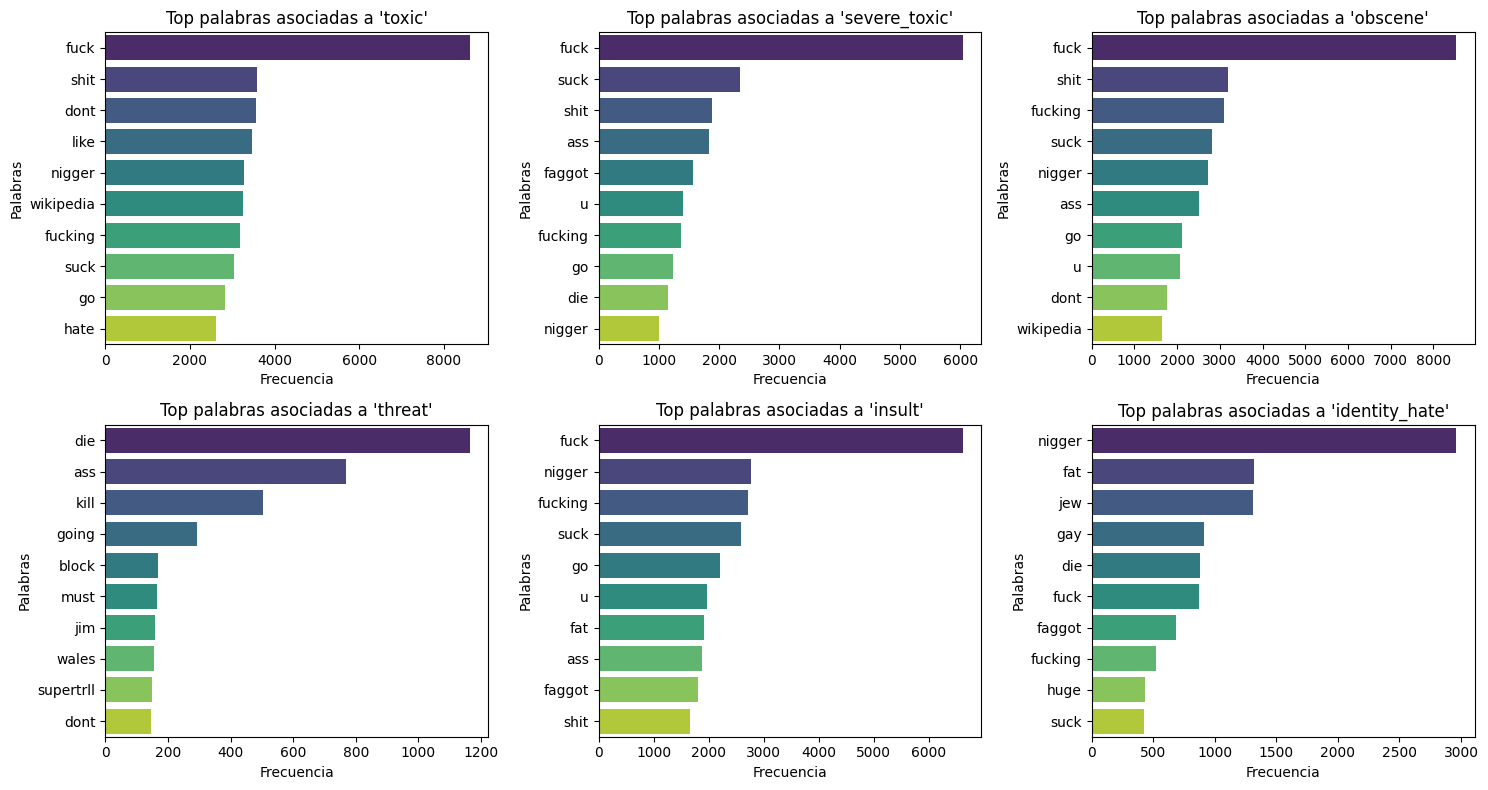

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_label_associated_words(label_words):
    """
    Genera una gráfica de barras para mostrar las palabras más asociadas a cada etiqueta.

    :param label_words: Diccionario donde la clave es la etiqueta y el valor es una lista de tuplas
                        (palabra, frecuencia).
    """

    import warnings # Importamos el módulo warnings para manejar advertencias
    warnings.filterwarnings("ignore", category=FutureWarning)  # Ignoramos advertencias FutureWarning específicas

    # Configurar tamaño de la figura
    plt.figure(figsize=(15, 8)) # Establecemos el tamaño de la figura (15 de ancho por 8 de alto)

    # Número de subplots (uno por etiqueta)
    num_labels = len(label_words) # Calculamos el número de etiquetas en el diccionario
    rows = (num_labels + 2) // 3  # Calculamos el número de filas necesarias para los subplots (3 columnas)

    for i, (label, words) in enumerate(label_words.items(), 1):
      # Recorremos las etiquetas y las palabras asociadas a cada una de ellas
        plt.subplot(rows, 3, i) # Creamos un subplot para cada etiqueta, organizados en filas y 3 columnas

        # Extraer palabras y frecuencias
        words_list, frequencies = zip(*words) # Separamos las palabras y las frecuencias

        # Crear gráfica de barras
        sns.barplot(x=frequencies, y=words_list, palette="viridis") # Graficamos las barras con 'seaborn'

        # Añadir títulos y etiquetas
        plt.title(f"Top palabras asociadas a '{label}'", fontsize=12) # Título de la gráfica
        plt.xlabel("Frecuencia", fontsize=10) # Etiqueta para el eje X
        plt.ylabel("Palabras", fontsize=10) # Etiqueta para el eje Y

    plt.tight_layout() # Ajusta automáticamente los márgenes y espaciado para evitar que las gráficas se superpongan
    plt.show() # Muestra la gráfica

# Llamar a la función con los datos generados
plot_label_associated_words(label_words)
